This notebook is for creating the base ML model.

In [1]:
model_name = "base_model_10_buckets" + "_model_files"

In [2]:
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_parquet('../../data_preparation/taxi_trip_data/all_tlc_data_10_buckets.parquet')
df.rename({'passenger_count':'busyness'},axis=1, inplace=True)
print(df.columns)

Index(['datetime', 'location', 'busyness'], dtype='object')


In [4]:
df.shape

(7319643, 3)

In [5]:
df.head()

datetime  location  busyness
0 2021-01-01         3         5
1 2021-01-01         4         7
2 2021-01-01         5         2
3 2021-01-01         6         2
4 2021-01-01         7         9

In [6]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="location",
    timestamp_column="datetime"
)
print(data.head())

                    busyness
item_id timestamp           
3       2021-01-01         5
4       2021-01-01         7
5       2021-01-01         2
6       2021-01-01         2
7       2021-01-01         9


In [7]:
prediction_length = 3 * 30 * 24 # 3 months prediction window
train_data, test_data = data.train_test_split(prediction_length)

In [8]:
# setting the frequency to h since the data is grouped/collected hourly,
# # added relative path 

predictor = TimeSeriesPredictor(
    freq='h',
    target="busyness",
    eval_metric="MASE",
    prediction_length=prediction_length,
    path=model_name
)
print('we made the predictor')

we made the predictor


In [9]:
predictions = predictor.fit(train_data,
                                presets="medium_quality"
                                )


Beginning AutoGluon training...
AutoGluon will save models to 'base_model_10_buckets_model_files'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.9.19
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          12
GPU Count:          1
Memory Avail:       1.38 GB / 15.90 GB (8.7%)
Disk Space Avail:   2140.12 GB / 2794.50 GB (76.6%)
Setting presets to: medium_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': MASE,
 'freq': 'h',
 'hyperparameters': 'light',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2160,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'busyness',
 'verbosity': 2}

train_data with frequency 'None' has been resampled to frequency 'h'.
Provided train_data has 6826363 rows (NaN fraction=1.0

In [10]:
print(predictor.leaderboard())

              model  score_val  pred_time_val  fit_time_marginal  fit_order
0  WeightedEnsemble  -1.239664       1.491648         104.065988          7
1     SeasonalNaive  -1.239664       1.491648           6.123166          2
2             Naive  -2.204200       7.115456           6.874734          1
3     DirectTabular  -2.378403      56.315088         197.123030          4
4             Theta  -2.641920      42.071119           4.824823          6
5  RecursiveTabular  -3.259668     610.980597         443.779239          3
6               ETS  -4.030379     192.544984           4.854713          5


In [11]:
predictions = predictor.predict(train_data)
print(predictions)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


                             mean      0.1       0.2       0.3       0.4  0.5  \
item_id timestamp                                                               
3       2024-01-01 23:00:00   7.0  5.81976  6.224912  6.517055  6.766681  7.0   
        2024-01-02 00:00:00   5.0  3.81976  4.224912  4.517055  4.766681  5.0   
        2024-01-02 01:00:00   7.0  5.81976  6.224912  6.517055  6.766681  7.0   
        2024-01-02 02:00:00   6.0  4.81976  5.224912  5.517055  5.766681  6.0   
        2024-01-02 03:00:00   5.0  3.81976  4.224912  4.517055  4.766681  5.0   
...                           ...      ...       ...       ...       ...  ...   
110     2022-04-23 13:00:00   1.0  1.00000  1.000000  1.000000  1.000000  1.0   
        2022-04-23 14:00:00   1.0  1.00000  1.000000  1.000000  1.000000  1.0   
        2022-04-23 15:00:00   1.0  1.00000  1.000000  1.000000  1.000000  1.0   
        2022-04-23 16:00:00   1.0  1.00000  1.000000  1.000000  1.000000  1.0   
        2022-04-23 17:00:00 

data with frequency 'None' has been resampled to frequency 'h'.


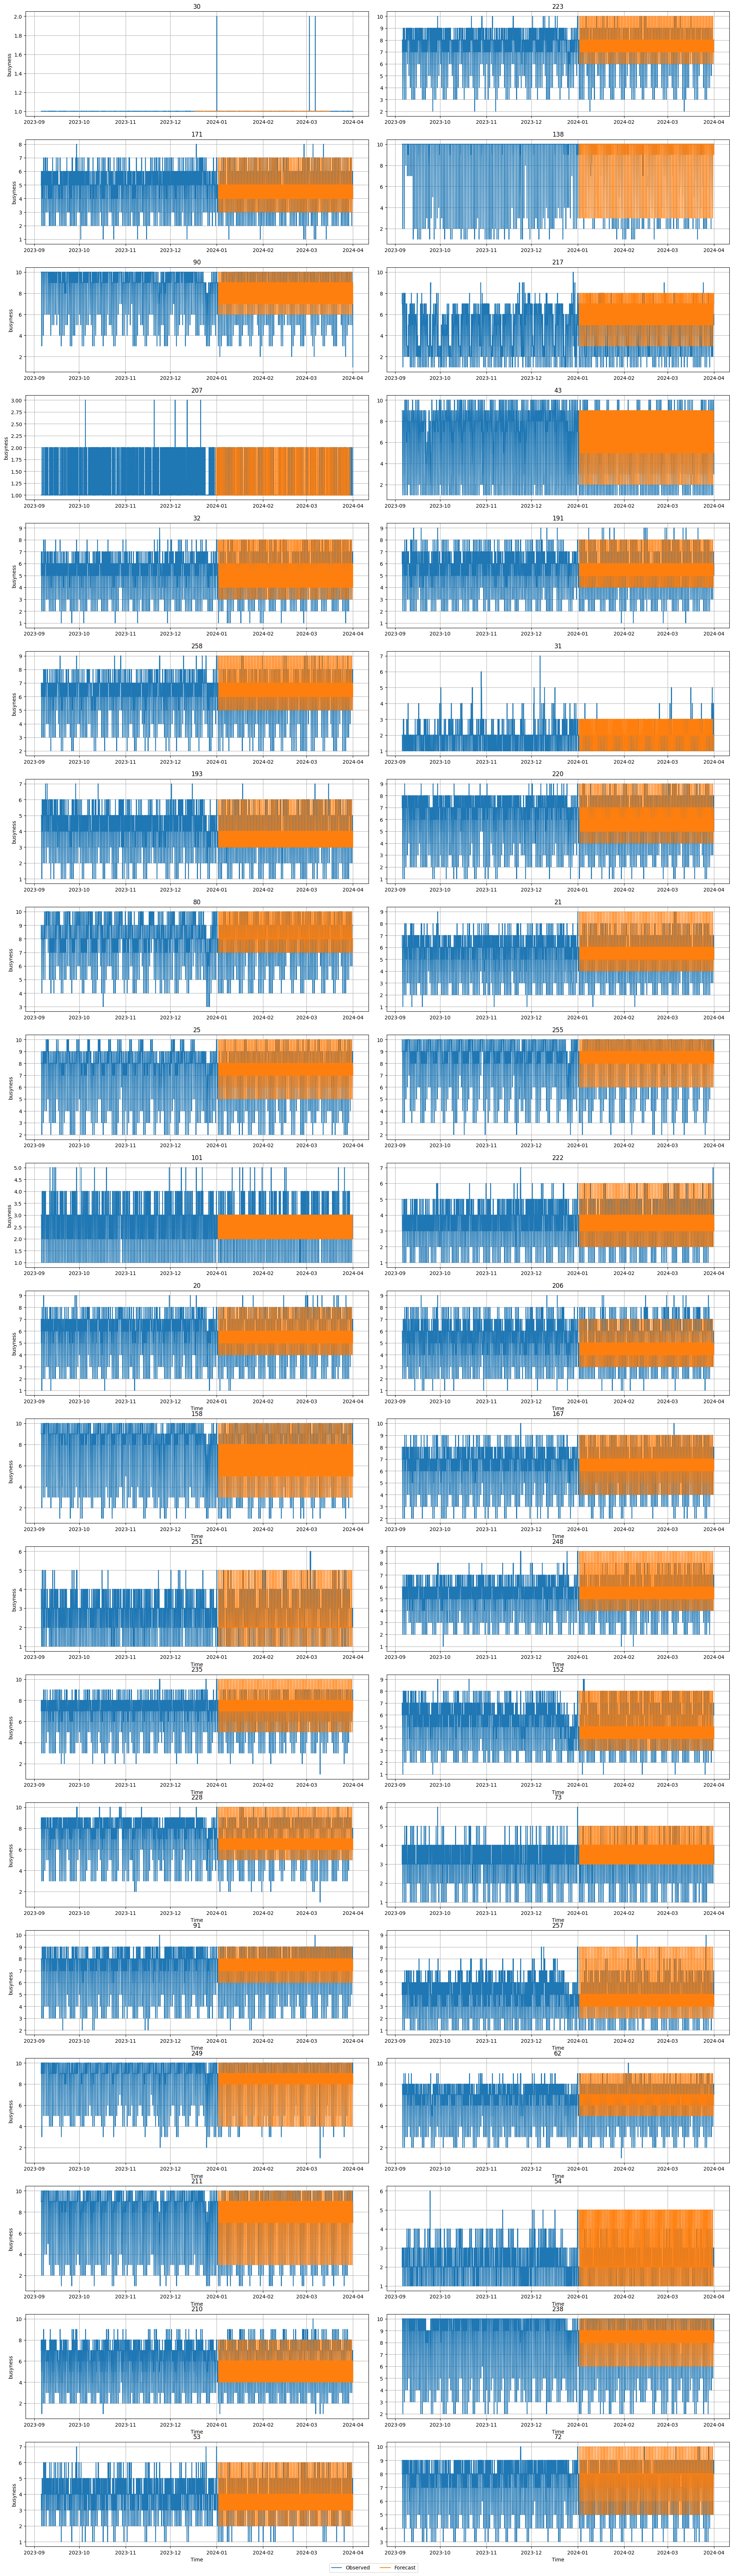

In [12]:
plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=40)


data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.
data with frequency 'None' has been resampled to frequency 'h'.


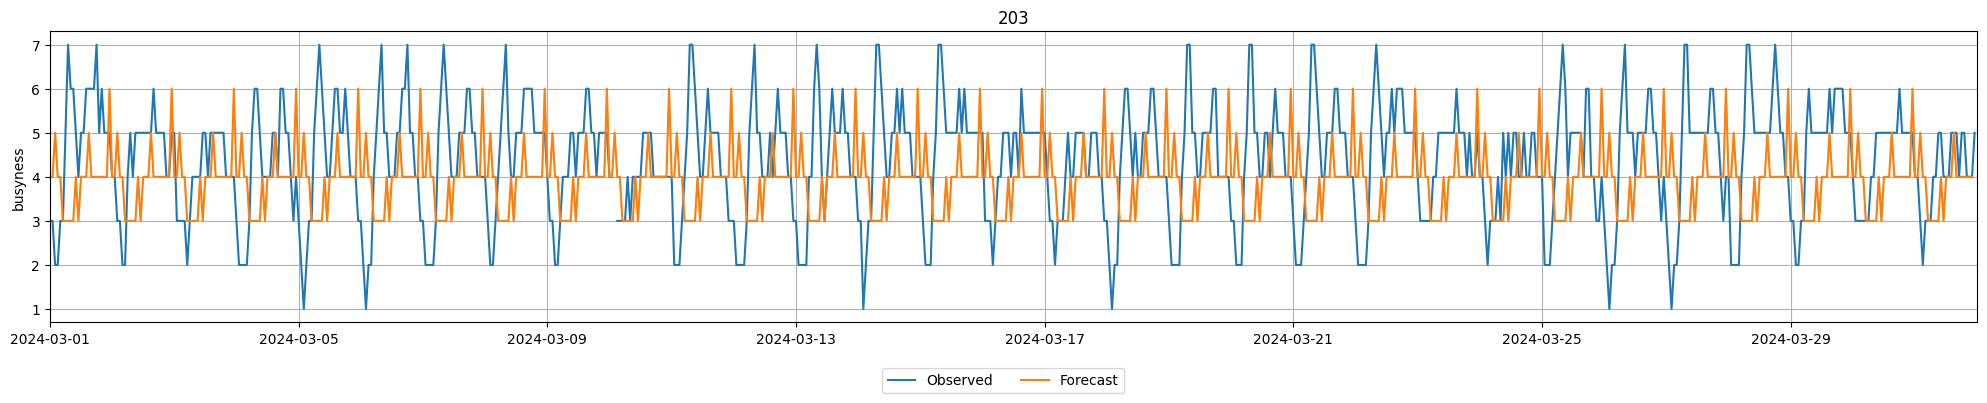

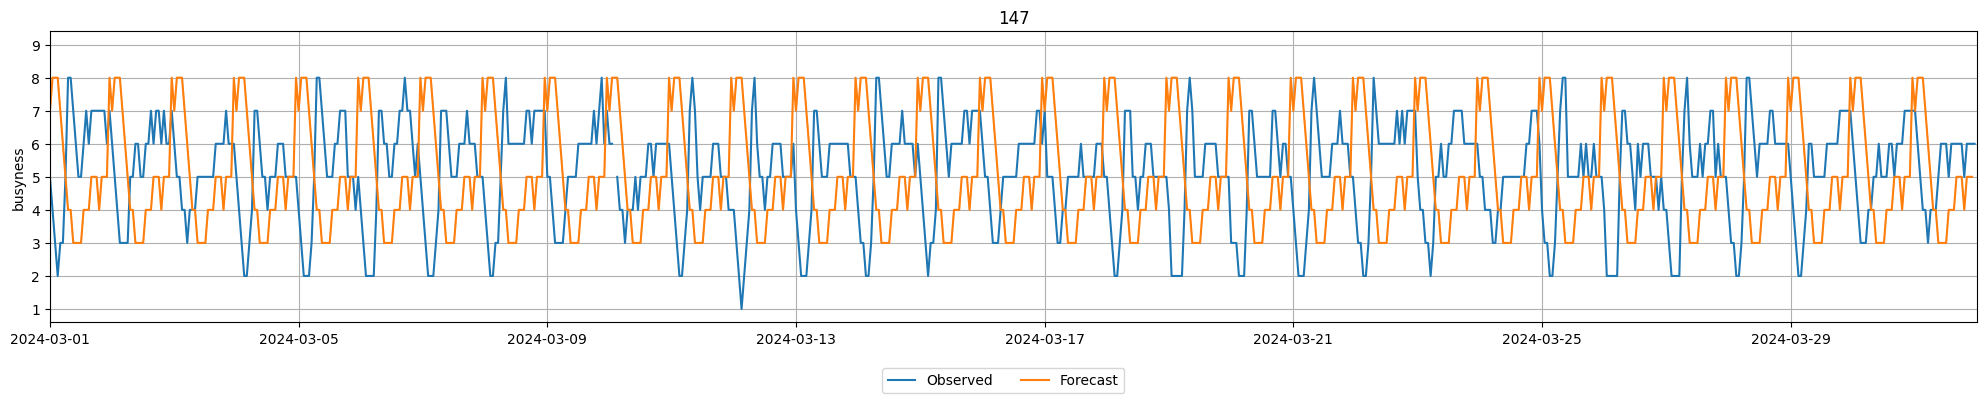

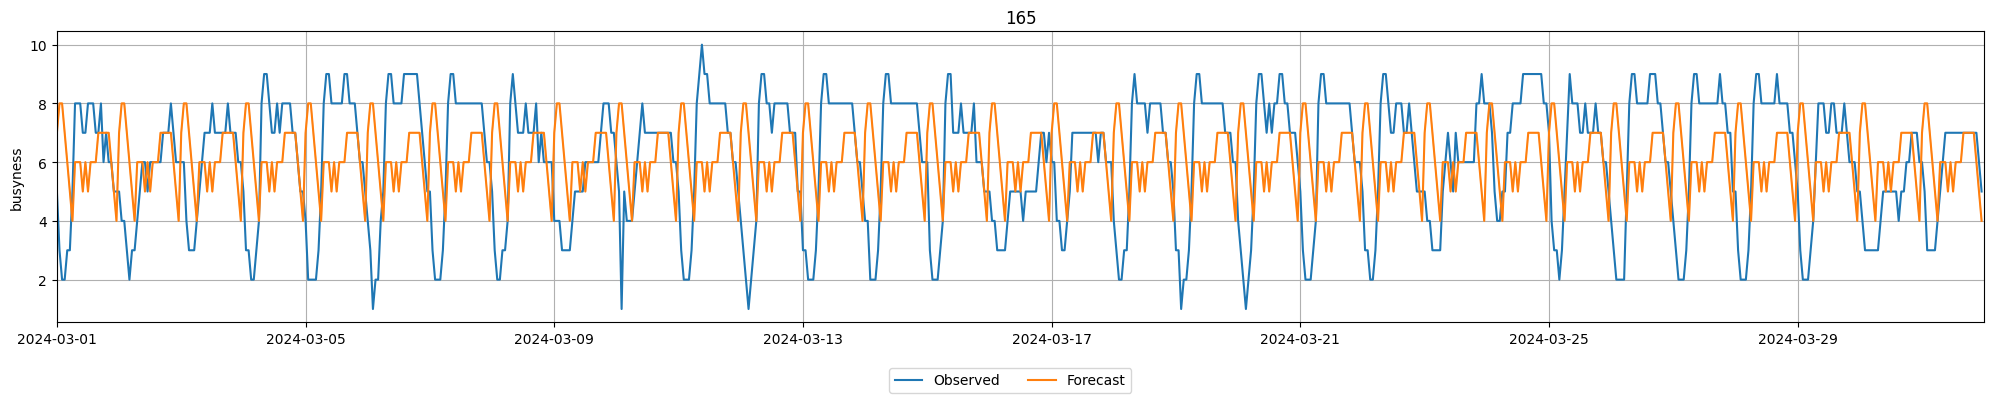

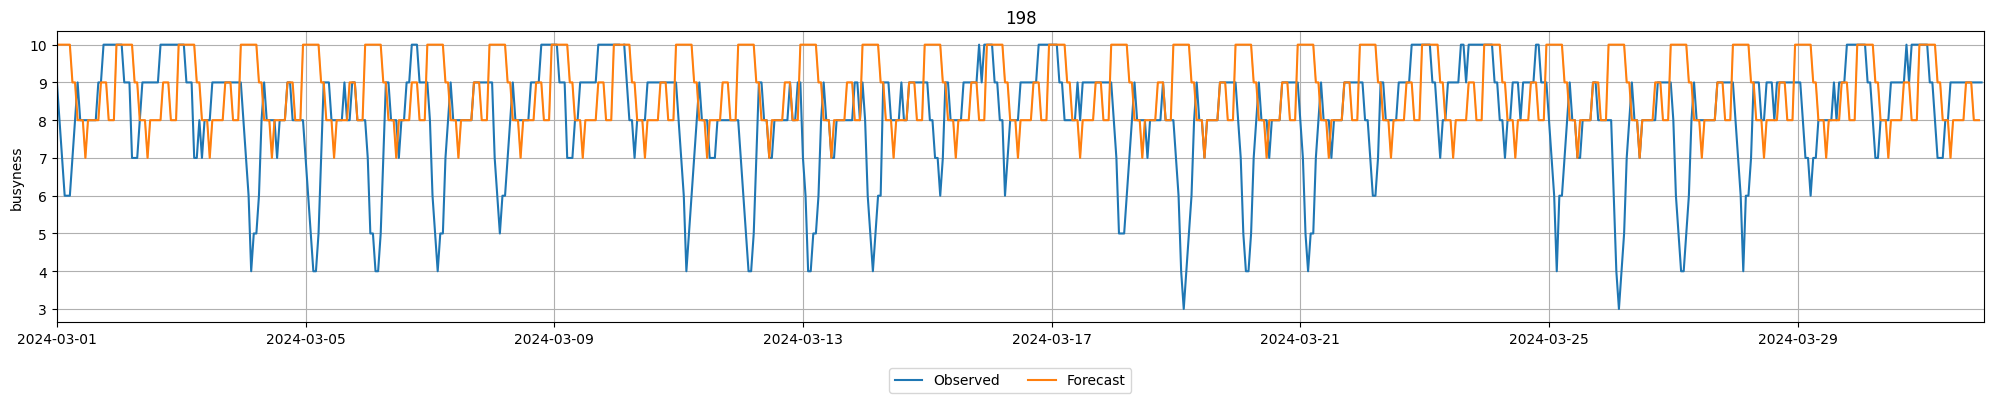

In [13]:
xmin = pd.Timestamp('2024-03-01 00:00:00')
xmax = pd.Timestamp('2024-03-31 23:59:59')
for i in range(4):
    plot = predictor.plot(test_data, predictions, quantile_levels=[0.5],  max_history_length=5000,  max_num_item_ids=1)
    ax = plot.gca()
    ax.set_xlim([xmin, xmax])
plt.show()

In [14]:
plt.show()

In [15]:
predictor.evaluate(test_data)

data with frequency 'None' has been resampled to frequency 'h'.
Model not specified in predict, will default to the model with the best validation score: SeasonalNaive


{'MASE': -3.0564223828492527}